In [1]:
import pandas as pd
import urllib
from bs4 import BeautifulSoup
import time
from fatsecret import Fatsecret
import matplotlib.pyplot as plt

In [2]:
datos=pd.read_excel('alimentos.xlsx',names=['Alimento'])
datos.head()
#Importo el archivo que tengo en excel con los alimentos que suelo comer

,Alimento
0,egg
1,Turkey
2,skimmed milk
3,oats
4,wholemeal bread


In [3]:
#Añado a cada cadena el valor 100g Generic para obtener los valores genericos de 100 gramos de dicho alimento por la API
datos['Consulta']=datos['Alimento'].apply(lambda x: x + ' 100g Generic') 

In [4]:
datos.head()

,Alimento,Consulta
0,egg,egg 100g Generic
1,Turkey,Turkey 100g Generic
2,skimmed milk,skimmed milk 100g Generic
3,oats,oats 100g Generic
4,wholemeal bread,wholemeal bread 100g Generic


In [5]:
#Me registro en la api con mi consumer key y mi consumer secret
fs = Fatsecret("####", "###")

In [6]:
#Obtengo los codigos de todos los alimentos
#La búsqueda en la API la haré con estos códigos
codigos=[]
for i in datos['Consulta']:
    foods = int(fs.foods_search(i)[0]['food_id']) #Obtengo todos los códigos de los alimentos
    codigos.append(foods)
    time.sleep(2)
datos["Codigos"]=codigos    

In [7]:
datos.head()

,Alimento,Consulta,Codigos
0,egg,egg 100g Generic,3092
1,Turkey,Turkey 100g Generic,1741
2,skimmed milk,skimmed milk 100g Generic,793
3,oats,oats 100g Generic,4764
4,wholemeal bread,wholemeal bread 100g Generic,3422


In [8]:
#Realizo la petición final en la que busco las calorías y gramos de cada macronutriente (Proteina,hidrato y grasa)
finito=[]
for a in datos['Codigos']:
    fino=fs.food_get(a)
    informacion_fina={
        "Codigos":a,
        'calorias':fino['servings']['serving'][0]['calories'],
        'carbohidratos':fino['servings']['serving'][0]['carbohydrate'],
        'grasas':fino['servings']['serving'][0]['fat'],
        'proteinas':fino['servings']['serving'][0]['protein']
    }
    finito.append(informacion_fina)
    time.sleep(2)

In [9]:
#Creo la tabla final sobre la que haré los cálculos de la dieta diariamente
datos2=pd.DataFrame(finito)
datos_final=datos.merge(datos2,left_on="Codigos", right_on="Codigos").drop(labels="Consulta",axis=1)
datos_final['cantidad(gramos)']=100 #Añado este valor ya que los cálculos se hacen sobre 100

In [10]:
datos_final.head()

,Alimento,Codigos,calorias,carbohidratos,grasas,proteinas,cantidad(gramos)
0,egg,3092,96,0.50,6.46,8.18,100
1,Turkey,1741,26,0,0.98,4.05,100
2,skimmed milk,793,122,11.49,4.88,8.03,100
3,oats,4764,311,54.27,5.10,12.96,100
4,wholemeal bread,3422,53,10.12,0.66,1.53,100


In [11]:
datos_final.to_csv("tabla_final_.csv",index=False)

In [12]:
#Creo la clase Usuario, cada objeto será un usuario y se pedirá lo necesario para hacer los cálculos personalizados
class Usuario:
    def __init__(self,peso,altura,edad,actividad,plan):
        self.peso=int(peso)
        self.altura=int(altura)
        self.edad=int(edad)
        self.actividad=actividad
        self.plan=plan
    def calorias(self):
        calorias=66.473+(13.715*self.peso)+(5.003*self.altura)-(6.755*self.edad)
        if self.plan=='subir':
            return int(calorias*1.5)
        elif self.plan=='bajar':
            return int(calorias-200)
    def macros(self,calorias):
        if self.plan=='subir':
            proteina=2.2*self.peso
            grasas=0.95*self.peso
            carbos=(calorias-proteina*4-grasas*9)/4
            return[proteina,grasas,carbos]
        else:
            proteina=2.5*self.peso
            grasas=0.7*self.peso
            carbos=(calorias-proteina*4-grasas*9)/4
            return[proteina,grasas,carbos]

In [13]:
print('''Introduzca separado por comas y sin espacios su peso,altura,edad,
actividad(alta,media o baja) y su plan(subir o bajar de peso),
Ejemplo(80,180,22,media,subir)''')
a="80,180,22,media,bajar"#Sería lo que hubiera introducido un usuario
a=a.split(',')
if a[3]=='baja':
    h=1.2
elif a[3]=='media':
    h=1.55
else:
    h=1,9

persona=Usuario(a[0],a[1],a[2],h,a[4])#Creo el objeto

Introduzca separado por comas y sin espacios su peso,altura,edad,
actividad(alta,media o baja) y su plan(subir o bajar de peso),
Ejemplo(80,180,22,media,subir)


In [14]:
persona.calorias()#Calorías a cumplir diariamente

1715

In [15]:
persona.macros(persona.calorias())#Gramos de proteinas, grasas y carbohidratos respectivamente

[200.0, 56.0, 102.75]

In [18]:
#Inicializar
calorias=0
carbohidratos=0
grasas=0
proteinas=0
calorias_restantes=0
carbo_restantes=0
grasas_restantes=0
proteina_restantes=0

Food :skimmed milk
Weight in grams:300
LLevas consumidas 366.0 calorias, 34.47 gramos de carbohidratos,14.64 gramos de grasas y 24.09 gramos de proteinas.
Te quedan por consumir 1349.0 calorias.
Te quedan por consumir 175.91 gramos de proteina.
Te quedan por consumir 68.28 gramos de carbohidratos.
Te quedan por consumir 41.36 gramos de grasa.



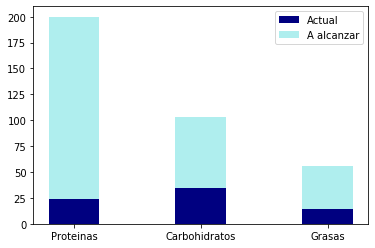

In [19]:
alimento=input('Food :')
cantidad=float(input('Weight in grams:'))
calorias=calorias+float(datos_final[datos_final['Alimento']==alimento]['calorias'])*cantidad/100
proteinas=proteinas+float(datos_final[datos_final['Alimento']==alimento]['proteinas'])*cantidad/100
carbohidratos=carbohidratos+float(datos_final[datos_final['Alimento']==alimento]['carbohidratos'])*cantidad/100
grasas=grasas+float(datos_final[datos_final['Alimento']==alimento]['grasas'])*cantidad/100

print("LLevas consumidas {} calorias, {} gramos de carbohidratos,{} gramos de grasas y {} gramos de proteinas.".format(calorias,carbohidratos,grasas,proteinas))
calorias_restantes=persona.calorias()-calorias #Calculo el calculado en la clase menos el acumulado
carbo_restantes=persona.macros(persona.calorias())[2]-carbohidratos
grasas_restantes=persona.macros(persona.calorias())[1]-grasas
proteina_restantes=persona.macros(persona.calorias())[0]-proteinas
print('''Te quedan por consumir {} calorias.
Te quedan por consumir {:.2f} gramos de proteina.
Te quedan por consumir {:.2f} gramos de carbohidratos.
Te quedan por consumir {:.2f} gramos de grasa.
'''.format(calorias_restantes,proteina_restantes,carbo_restantes,grasas_restantes))

p1 = plt.bar(x=range(3), height=[proteinas,carbohidratos,grasas], 
width=0.4,color='navy')
p2 = plt.bar(x=range(3), height=[proteina_restantes,carbo_restantes,grasas_restantes], 
width=0.4,color="paleturquoise",bottom=[proteinas,carbohidratos,grasas])
plt.legend(["Actual", "A alcanzar"])
plt.xticks(range(3),["Proteinas","Carbohidratos","Grasas"])
plt.show()